# Interacting Fermions on a 1D Lattice
## Quantum circuit of Hubbard Hamiltonian for *Variational Quantum Eigensolver*

The goal of this tutorial is to simulate the physics of interacting spin-half fermions on a one-dimensional lattice on a quantum computer. The Hamiltonian of the system is described by the Hubbard model where in addition to the hopping between lattice sites, fermions with opposite spins, interact via an on-site Coulomb potential. The ground state energy and its corresponding wavefunction are to be calculated using a hybrid quantum-classical algorithm called *Variational Quantum Eigensolver* (VQE). Implementation of the quantum circuit of the VQE  algorithm in *qiskit* is layed out in here. 

# Table of contents

1. [Theory](#theory)
    1. [Hubbard Model of Interacting Fermions](#hubbard)
    2. [Mapping to Qubits: *Jordan-Wigner Transformation*](#map)
    3. [*Variational Quantum Eigensolver*](#vqe)
    4. [Ansatz Wavefunction: *Variational Hamiltonian*](#ansatz)

2. [Implementation](#implement)
    1. [Initialization](#init)
    2. [Quantum Circuit: Initial](#circuit-initial)
    3. [Quantum Circuit: Ansatz](#circuit-ansatz)
    4. [Quantum Circuit: Measurement](#circuit-measurement)
    5. [Complete Quantum Circuit](#circuit-complete)

5. [Appendix](#app)
    1. [Hamiltonian in terms of Pauli gates](#hamiltonian-pauli)
    2. [Time evolution in terms of basic gates](#rotation-basic)
    
6. [References](#ref)

# Theory <a name='theory'></a>


## Hubbard Model of Interacting Fermions <a name='hubbard'></a>

The system consists of a one-dimensional lattice where each site represents a single atomic orbital accommodating at most two electrons with opposite spins. 
The spin-up and spin-down electrons interact only on the same site through Coulomb potential. 
Figure below illustrates a lattice of $M$ orbitals where electrons can *hop* only to their nearest neighboring sites. 

<img src="fig/lattice-open.png" alt="lattice" width="350"/> 

The Hamiltonian of the system, given by the [*Hubbard* model](https://en.wikipedia.org/wiki/Hubbard_model), is written as a sum of non-interacting and interacting parts, i.e. $H=H_0 + H_U$, as follows  

$$
H = -t\sum_{\sigma}\sum_{\langle ij\rangle}a^\dagger_{j,\sigma}a_{i,\sigma} + U\sum_{i}\hat{n}_{i,\uparrow}\hat{n}_{i,\downarrow},
$$  

where the variables are defined as 
- $t$: hopping energy, proportional to the overlap integral of neighboring orbitals
- $\sigma=\uparrow,\downarrow$: spin index
- $\langle ij\rangle$: site indices where $i$ and $j$ denote adjacent sites
- $a^\dagger_{i,\sigma},~a_{i,\sigma}$: creation and annihilation operators on $i$-th site
- $U$: the on-site Coulomb energy 
- $\hat{n}_{i,\sigma}=a^\dagger_{i,\sigma}a_{i,\sigma}$: occupation number operator  

Here $t$ and $U$ are the free parameters of the model. The objective is to find the ground state energy and wavefunction of the system with respect to different values of $t$ and $U$. 

## Mapping to Qubits: *Jordan-Wigner Transformation* <a name='map'></a>

To simulate fermions on a quantum computer one needs to utilize a mapping that mimics the exchange statistics of the fermions on the qubits. 
[*Jordan-Wigner* transformation](https://en.wikipedia.org/wiki/Jordan-Wigner_transformation) provides a simple mapping that satisfies the symmetrization requirement of fermions. 
Within this method, the occupation number of a given orbital is stored as $|0\rangle$ or $|1\rangle$ state of a qubit representing an empty or an ocupied state, respectively. Therefore, for a system with $M$ orbitals, the *occupation number* representation of $2M$ corresponding qubits (2 spins per orbital) is given as  

$$
|n_{M-1\downarrow},\cdots,n_{0\downarrow}, n_{M-1\uparrow},\cdots,n_{0\uparrow}\rangle
$$  

where the first $M$ qubits (least significant bits) represent the spin-up states and the next $M$ qubits represent the spin-down states and $n_{i\sigma}$ is the occupation number of i-th orbital with spin $\sigma=\uparrow,\downarrow$. 
In this representation, the fermionic creation and annihilation operators are mapped to the following operations on the qubits  

$$
a_{i\sigma} = I_{M-1\sigma}\otimes\cdots\otimes I_{i+1\sigma}\otimes Q_{i\sigma}\otimes Z_{i-1\sigma}\otimes\cdots\otimes Z_{0\sigma},
$$
$$
a^\dagger_{i\sigma} = I_{M-1\sigma}\otimes\cdots\otimes I_{i+1\sigma}\otimes Q^\dagger_{i\sigma}\otimes Z_{i-1\sigma}\otimes\cdots\otimes Z_{0\sigma}, 
$$  

where $Q = |0\rangle\langle 1| = (X + iY)/2$ changes the occupation number of the i-th site and $Z$ operators recover the sign of fermionic exchange. Also, $X, Y,$ and $Z$ represent Pauli gates. Replacing the creation and annihilation operators, in the Hamiltonian above, with their corresponding qubit operations, one obtains the Hamiltonian in terms of single qubit Pauli gates as follows (see [Appendix A](#hamiltonian-pauli))  

$$
H = -\frac{t}{2}\sum_{\sigma}\bigg[\sum_{i=2k}X_{i\sigma}X_{i+1\sigma} + Y_{i\sigma}Y_{i+1\sigma} + \sum_{i=2k+1}X_{i\sigma}X_{i+1\sigma} + Y_{i\sigma}Y_{i+1\sigma}\bigg] + \frac{U}{4}\sum_{i}(I - Z_{i\uparrow} - Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow}),
$$ 

where the even and odd hopping terms are separated. As will be explained later, although the even and odd terms commute with each other, they require different two-qubit gate configuration in the ansatz circuit. 

## *Variational Quantum Eigensolver*<a name='vqe'></a>

Similar to its classical counterpart, *Variational Quantum Eigensolver* (VQE) is a [*variational method*](https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics)) for calculating the ground state energy and wavefunction of a given Hamiltonian. VQE is a hybrid quantum-classical algorithm where a parameterized ansatz wavefunction is variationally brought to the vicinity of the ground state. The set of parameters that minimize the energy for a given ansatz wavefunction, are the solution to the problem. 
The algorithm consists of two parts: a **quantum circuit** and a **classical optimizer**. 
The quantum circuit performs two tasks: first generate the ansatz wavefunction of the system given the variational parameters as the input, and second measure the energy (expectation value of Hamiltonian) with respect to that wavefunction. The result of the measurement is then fed into the classical optimizer to generate a new set of variational parameters wich will hopefully lead to a lower energy.
The following figure illustrates the workings of the VQE algorithm schematically.  

<img src="fig/vqe.png" alt="vqe" width="350"/>  

The algorithm starts with a set of variational parameters ${\bf \theta}^{(0)}$. The ansatz wavefunction $|\psi(\theta^{(0)})\rangle$ is then genereted on the quantum computer by implementing the ansatz circuit represented by the unitary operator $U(\theta^{(0)})$, i.e. $|\psi(\theta^{(0)})\rangle=U(\theta^{(0)})|\psi_\text{I}\rangle$. Here $|\psi_\text{I}\rangle$ is the initial wavefunction which is usually chosen to be the ground state of the non-interacting Hamiltonian $H_0$ and it should be relatively easy to prepare it on the quantum computer.
Measuring the expectation value of Hamiltonian with respect to the ansatz, one obtains the energy of the system which is strictly greater than or equal to the ground state energy, i.e. $E_0$. Hence,  

$$ 
E(\theta^{(0)}) = \langle\psi(\theta^{(0)})|H|\psi(\theta^{(0)})\rangle \ge E_0\cdot
$$  

Finally, the classical optimizer generates a new set of parameters $\theta^{(1)}$, which are dependent on the previous parameters and energies. 
The new parameters are fed back into the ansatz circuit to generate a new wavefunction with a lower energy. 
Here, the optimizer is modeled as a basic search algorithm where the space of parameters are sampled randomly.
The whole process is repeated all over again until the energy $E(\theta^{(n)})$ is sufficiently close to the ground state energy. Hence, $\theta^{(n)}$ will be the solution to the problem and any information of the system can be extracted by first generating the wavefunction $|\psi(\theta^{(n)})\rangle$ on the quantum computer and then measuring the desired observables.  


## Ansatz Wavefucntion: *Variational Hamiltonian*<a name='ansatz'></a>

The most essential part of the variational method is generating a suitable ansatz wavefunction. 
The method used here is closely related to the [*adiabatic quantum computation*](https://en.wikipedia.org/wiki/Adiabatic_quantum_computation) where an initial wavefunction $\psi_\text{I}$ which is the ground stete of $H_0$ is prepared and then [adiabatically](https://en.wikipedia.org/wiki/Adiabatic_theorem) evolved in time to the ground state of the full Hamiltonian $H$. 
The time evolution is applied by using the [Trotter-Suzuki expansion](https://en.wikipedia.org/wiki/Time-evolving_block_decimation#The_Suzuki-Trotter_expansion) where the time evolution operator is broken into a sequence of short-time unitary rotations. 
The [*Variational Hamiltonian*](#weck) method, used in this work, is based on a modified version of Trotter-Suzuki expansion. 
The modification is that the time parameter in each step of the sequence of unitary rotations is replaced by arbitrary rotation angles which are the variational parameters $\theta$. 
Therefore, $U(\theta)$ is written as $\Pi_j U(\theta_j)$.
Figure below illustrates the $U(\theta)$ circuit where the time evolution is divided into $S$ steps with different variational parameter $\theta_j$.  

<img src="fig/ansatz.png" alt="ansatz-circuit" width="350"/>  

Each unitary rotation $U(\theta_j)$ is further divided into products of rotations with respect to different terms in the Hamiltonian, i.e.  

$$
U(\theta_j) = \exp(i\theta_jH) = \exp(i\theta_{j,xe}H_{xe}) \exp(i\theta_{j,xo}H_{xo}) \exp(i\theta_{j,ye}H_{ye}) \exp(i\theta_{j,yo}H_{yo}) \exp(i\theta_{j,z}H_U),
$$  

where $H_{x(y)e(o)}$ denotes the even (odd) XX (YY) hopping terms. Therefore, there are $5S$ variational parameters in total. Each of the unitary rotations above must be converted into basic gates for implementation on a quantum computer (see [Appendix B](#rotation-basic)). 

## Energy Measurement <a name='energy'></a>

Given the ansatz wavefunction $\psi(\theta)$, one needs to measure the energy of the system which is the expectation value of the Hamiltonian i.e. $E(\theta) = \langle\psi(\theta)|H|\psi(\theta)\rangle$. Decomposing $H$ into 5 **commuting** terms as before, $H = H_{xe} + H_{ye} + H_{xo} + H_{yo} + H_U$, one obtains 

$$
E(\theta) = \langle H_{xe}\rangle + \langle H_{ye}\rangle + \langle H_{xo}\rangle + \langle H_{yo}\rangle + \langle H_U\rangle. 
$$

This allows one to measure energy contribution of each term separately and then summing them up. Therefore, the measurement circuit for each term will only be of depth 1, i.e. $\text{X}$ gates for $H_{xe(o)}$ terms and $\text{Y}$ gates for $H_{ye(o)}$ terms. There needs not be any circuit for measuring the energy of $H_U$ for one needs to measure only the number of double occupancies which is done by measuring the wavefunction directly. 
It should be noted that a large number of measurements is required to obtain the energy accurately which is one of the donwsides of the VQE algorithm. 

# Implementation <a name='implement'></a>

This section lays out the implementation of the VQE circuit in *qiskit*. It is assumed that the lattice is made of odd number of sites (orbitals). 

## Initialization <a name='init'></a>

In this part, the external libraries `numpy`, `copy`, and `qiskit` are first imported. The lattice is then defined by initializing the following parameters: number of orbitals `M`, hopping energy `t`, Coulomb energy `U`, number of spin-up electrons `Nu`, and number of spin-down electrons `Nd`. The variational parameters are initialized as well where `S` is the number of Trotter-Suzuki steps and `theta` is the set of variational parameters. The quantum circuit, which is an object of `QuantumCircuit` class in qiskit, is then initialized with $2M$ qubits. 


In [1]:
# initialization

# python libraries
import numpy as np
from copy import deepcopy

# qiskit libraries
from qiskit import *
from qiskit.tools.visualization import *

# define the lattice
M  = 5    # number of lattice sites 
t  = 1.0  # hopping energy
U  = 0.1  # Coulomb energy
Nu = 3    # number of spin-up electrons 
Nd = 3    # number of spin-down electrons 

# initialize variational parameters 
S     = 3                     # number of Trotter-Suzuki steps 
theta = np.random.rand(S, 5)  # 5 Hamiltonian terms in each step 

# initialize the circuit 
circ_empty = QuantumCircuit(2*M)

## Quantum Circuit: initial <a name='circuit-initial'></a>
A function called `compose_initial_circuit()` is defined to generate the initial wavefunction $\psi_\text{I}$ which is the solution to the non-interacting Hamiltonian $H_0$ and depends on the filling factor of the system, i.e. `Nu` and `Nd`. This function initializes the spin-up electrons on qubits $0$ to $N_u-1$ and the spin-down electrons on qubits $M$ to $M+N_d-1$. 

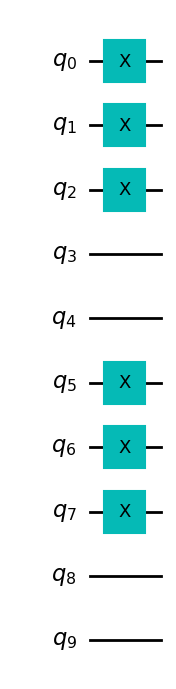

In [2]:
# compose quantum circuit 

def compose_initial_circuit(circuit, _M, _Nu, _Nd):
    for i in range(_Nu):
        circuit.x(i) 
    for i in range(_Nd): 
        circuit.x(_M+i)
    return circuit

circ_initial = compose_initial_circuit(deepcopy(circ_empty), M, Nu, Nd)
circ_initial.draw(output = 'mpl')

## Quantum Circuit: Ansatz <a name='circuit-ansatz'></a>
A function called `compose_ansatz_circuit()` is defined to generate the parameterized ansatz wavefunction. The variational parameters `theta` are given as an input to this function. 

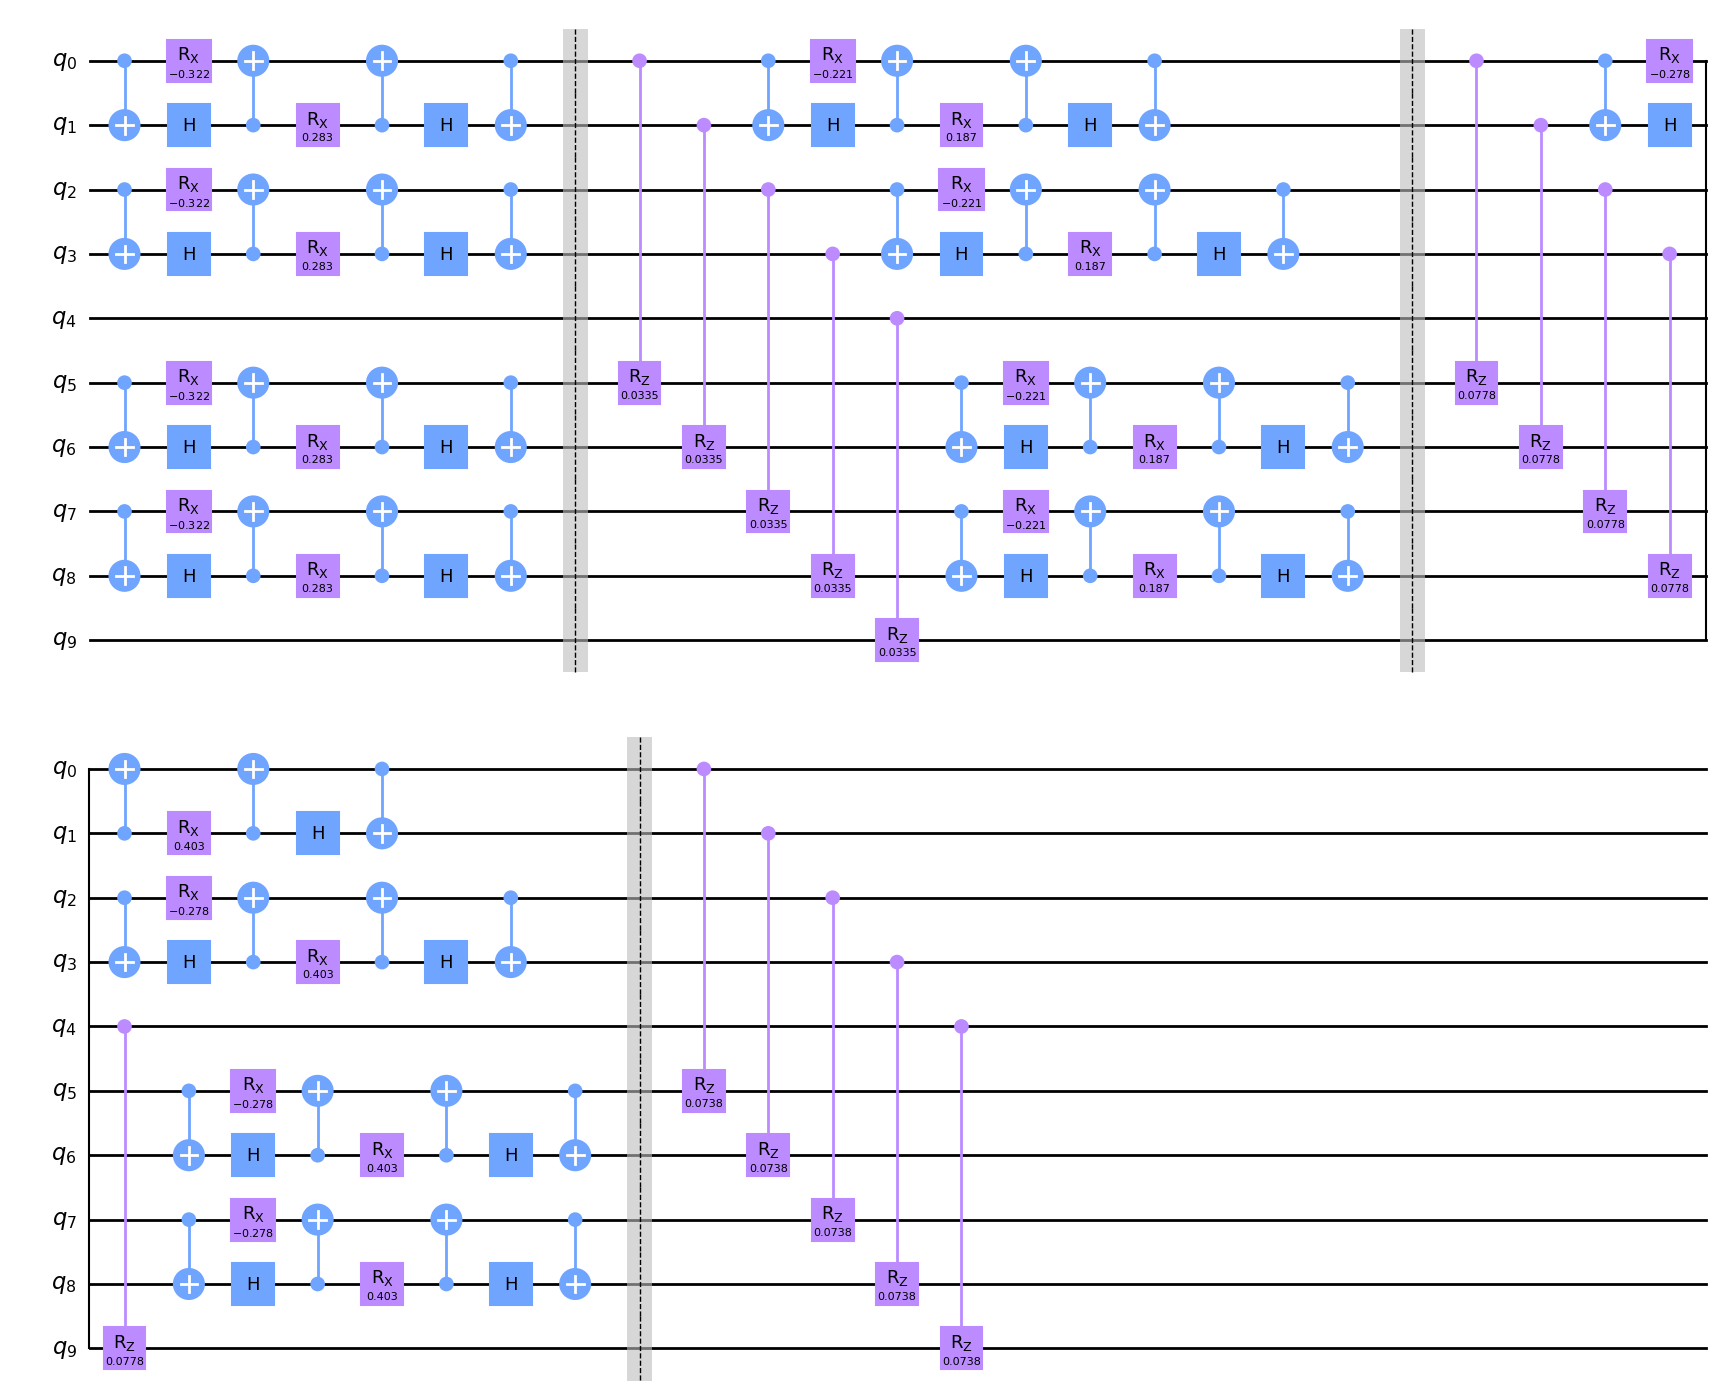

In [3]:
# compose quantum circuit 

def compose_ansatz_circuit(circuit, _M, _S, _theta): 
    # scale theta based on t and U
    _theta[:, :4] = -t/2.0*_theta[:, :4]
    _theta[:, 4] = U*_theta[:, 4]
    # loop over S Trotter-Suzuki steps 
    for j in range(_S):
        # XX and YY interactions: loop over even and odd terms
        for parity in [0]:
            # loop over orbitals
            for i in range(_M-1):
                if i%2 == parity:
                    # loop over spin up and down qubits
                    for spin_index in [0, _M]: 
                        circuit.cx(spin_index+i, spin_index+i+1)
                        circuit.rx(_theta[j, 2*parity+0], spin_index+i)    # theta_j,xe(o)
                        circuit.h(spin_index+i+1)
                        circuit.cx(spin_index+i+1, spin_index+i)
                        circuit.rx(-_theta[j, 2*parity+1], spin_index+i+1) # theta_j,ye(o)
                        circuit.cx(spin_index+i+1, spin_index+i)
                        circuit.h(spin_index+i+1)
                        circuit.cx(spin_index+i, spin_index+i+1) 
        # barrier
        circuit.barrier()
        # ZZ interactions
        # loop over orbitals
        for i in range(_M):
            circuit.crz(_theta[j, 4], i, _M+i)
    return circuit

circ_ansatz = compose_ansatz_circuit(deepcopy(circ_empty), M, S, theta)
circ_ansatz.draw(output = 'mpl')

## Quantum Circuit: Measurement <a name='circuit-measurement'></a>

A function called `compose_measurement_circuit()` is defined to implement the circuit for energy measurement. The argument `which_term` denotes the Hamiltonian terms: `"xe"`, `"xo"`, `"ye"`, `"yo"`, `"z"`.

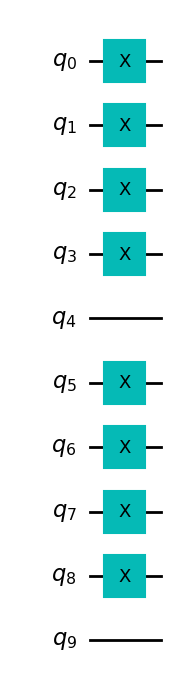

In [4]:
# compose quantum circuit 

def compose_measurement_circuit(circuit, _M, which_term):
    if which_term == "xe": 
        for i in range(_M-1):
            circuit.x(i)
            circuit.x(_M+i)
    elif which_term == "xo": 
        for i in range(_M-1):
            circuit.x(i+1)
            circuit.x(_M+i+1)
    elif which_term == "ye": 
        for i in range(_M-1):
            circuit.y(i)
            circuit.y(_M+i)
    elif which_term == "yo": 
        for i in range(_M-1):
            circuit.y(i+1)
            circuit.y(_M+i+1)
    else:
        pass
    return circuit 

circ_measurement = compose_measurement_circuit(deepcopy(circ_empty), M, "xe")
circ_measurement.draw(output = 'mpl')

## Complete Quantum Circuit <a name='circuit-complete'></a>

Finally, the complete quantum circuit that would run on the quantum computer is composed as follows. 

In [5]:
circ_complete = circ_initial + circ_ansatz + circ_measurement
circ_complete.draw(output = 'mpl')

TypeError: unsupported operand type(s) for +: 'QuantumCircuit' and 'QuantumCircuit'


# Appendix <a name='app'></a>

## Appendix A: Hamiltonian in terms of Pauli gates <a name='hamiltonian-pauli'></a>

Applying Jordan-Wigner transformation, one can represent the Hamiltonian of the system in terms of a sum of products of Pauli gates. The non-interacting part of Hamiltonian $H_0$ consists of hopping term between adjacent sites, i.e. $a^\dagger_{i+1}a_i + a^\dagger_ia_{i+1}$. Therefore, 

$$
a^\dagger_{i+1}a_i = (\frac{X_{i+1} - iY_{i+1}}{2})Z_i\cdots Z_0(\frac{X_i + iY_i}{2})Z_{i-1}\cdots Z_0
$$
$$
= (\frac{X_{i+1} - iY_{i+1}}{2})(\frac{Z_iX_i + iZ_iY_i}{2}) = (\frac{X_{i+1} - iY_{i+1}}{2})(\frac{X_i + iY_i}{2})
$$
$$
=\frac{1}{4}(iX_{i+1}Y_i + X_{i+1}X_i + Y_{i+1}Y_i - iY_{i+1}X_i)\cdot
$$  

Similarly,  

$$
a^\dagger_ia_{i+1} = \frac{1}{4}(iX_iY_{i+1} + X_iX_{i+1} + Y_iY_{i+1} - iY_iX_{i+1})\cdot
$$  

Therefore the hopping term between sites $i$ and $i+1$ in terms of Pauli gates are

$$
a^\dagger_{i+1}a_i + a^\dagger_ia_{i+1} = \frac{1}{2}(X_iX_{i+1} + Y_iY_{i+1})\cdot 
$$  

The interacting part of Hamiltonian $H_U$ consists of terms such as $a^\dagger_{i\uparrow}a_{i\uparrow} a^\dagger_{i\downarrow}a_{i\downarrow}$. Therefore, 

$$
a^\dagger_{i}a_{i} = (\frac{X_i - iY_i}{2})Z_{i-1}\cdots Z_0(\frac{X_i + iY_i}{2})Z_{i-1}\cdots Z_0 = \frac{1}{2}(I - Z_i),
$$
$$
a^\dagger_{i\uparrow}a_{i\uparrow} a^\dagger_{i\downarrow}a_{i\downarrow} = \frac{1}{4}(I - Z_{i\uparrow} - Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow})\cdot
$$  

## Appendix B: Time evolution in terms of basic gates <a name='rotation-basic'></a>

The time evolution operators $U(\theta_j)$ are composed of unitary rotations with respect to different terms of the Hamiltonian

$$
U(\theta_j) = \exp(i\theta_j(H_0 + H_U)) = \exp(i\theta_{j,xe}H_{xe}) \exp(i\theta_{j,xo}H_{xo}) \exp(i\theta_{j,ye}H_{ye}) \exp(i\theta_{j,yo}H_{yo}) \exp(i\theta_{j,z}H_U),
$$  

where  

$$
\exp(i\theta_{j,xe}H_{xe}) = \Pi_{\sigma}\Pi_{i=2k}\exp(-\frac{t}{2}i\theta_{j,xe}X_{i\sigma}X_{i+1\sigma}),
$$
$$
\exp(i\theta_{j,ye}H_{ye}) = \Pi_{\sigma}\Pi_{i=2k}\exp(-\frac{t}{2}i\theta_{j,ye}Y_{i\sigma}Y_{i+1\sigma}),
$$
$$
\exp(i\theta_{j,z}H_U) = \Pi_{i}\exp(\frac{U}{4}i\theta_{j,z}(I - Z_{i\uparrow} - Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow}))\cdot
$$  

Therefore, it suffices to find sequences of basic gates that implement XX, YY, and ZZ interactions described by unitary rotations $\exp(i\theta X_iX_j)$, $\exp(i\theta Y_iY_j)$, and $\exp(i\theta(I - Z_{i\uparrow} - Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow}))$, respectively.  

## XX interaction 

By Taylor expanding $\exp(i\theta X_iX_j)$, one obtains  

$$
e^{i\theta X_iX_j} = I + \frac{i}{1!}\theta^1X_iX_j - \frac{1}{2!}\theta^2I - \frac{i}{3!}\theta^3X_iX_j + \cdots
\\
= \bigg[I - \frac{\theta^2}{2!} + \frac{\theta^4}{4!} + \cdots\bigg] + iX_iX_j\bigg[\frac{\theta}{1!} - \frac{\theta^3}{3!} + \cdots\bigg]\\
= I\cos(\theta) + iX_iX_j\sin(\theta)\cdot
$$

Therefore, the matrix form of this interaction is

$$
e^{i\theta X_iX_j} = 
\begin{pmatrix}
\cos(\theta) & 0 & 0 & i\sin(\theta) \\
        0 & \cos(\theta) & i\sin(\theta) & 0 \\
        0 & i\sin(\theta) & \cos(\theta) & 0 \\
        i\sin(\theta) & 0 & 0 & \cos(\theta)
\end{pmatrix}\cdot
$$

This matrix represents a two-qubit gate which cannot be written as a tensor product of two single-qubit gates. After some algebra one obtains the sequence of basic gates that implements this matrix on qubits $i$ and $j$ as follows

$$
e^{i\theta X_iX_j} = \text{CX}_i\cdot \text{Rx}_i(\theta)\otimes\text{I}_j\cdot \text{CX}_i,
$$  

where $\text{CX}_i$ denotes a CNOT gate between qubits $i$ and $j$ where qubit $i$ is the *control*. 

## YY interaction

In a similar manner one obtains $\exp(i\theta Y_iY_j)=I\cos(\theta) + iY_iY_j\sin(\theta)$. Therefore, 

$$
e^{i\theta Y_iY_j} = 
\begin{pmatrix}
\cos(\theta) & 0 & 0 & -i\sin(\theta) \\
        0 & \cos(\theta) & i\sin(\theta) & 0 \\
        0 & i\sin(\theta) & \cos(\theta) & 0 \\
        -i\sin(\theta) & 0 & 0 & \cos(\theta)
\end{pmatrix}
$$  

The sequence of gates implementing YY interaction is obtained as  

$$
e^{i\theta Y_iY_j} = \text{CX}_i \cdot I_i\otimes H_j\cdot\text{CX}_j\cdot I_i\otimes\text{Rx}_j(-\theta)\cdot\text{CX}_j \cdot I_i\otimes H_j\cdot\text{CX}_i\cdot
$$  

Since the XX interaction ends with a CNOT gate and the YY interaction starts with a CNOT gate, the depth of the circuit can be reduced by three by placing XX and YY interactions in series. That is because the two CNOT gates cancel each other out and the $\text{Rx}_i(\theta)$ can be implemented in parallel with $H_j$ because $\text{Rx}_i(\theta)\otimes\text{I}_j\cdot I_i\otimes H_j = \text{Rx}_i(\theta)\otimes H_j$. Therefore, one obtains 

$$
e^{i\theta X_iX_j}e^{i\theta Y_iY_j} =  \text{CX}_i\cdot \text{Rx}_i(\theta)\otimes H_j \cdot \text{CX}_j\cdot I_i\otimes\text{Rx}_j(-\theta)\cdot\text{CX}_j \cdot I_i\otimes H_j\cdot\text{CX}_i\cdot
$$


## ZZ interaction 

Similarly, it can be shown that  

$$
e^{i\theta(I - Z_{i\uparrow} - Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow})} = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & e^{i\theta}
\end{pmatrix} 
= \text{cRz}(\theta), 
$$  

which is simply implementd by a controlled Z rotation, where qubit $i\uparrow$ is the *control* and qubit $i\downarrow$ is the *target*. Figure below illustrates the final unitary rotation circuit $U(\theta_j)$ for a lattice with $M=3$ orbitals where $q[0], q[1], q[2]$ represent spin-up states and $q[3], q[4], q[5]$ represent spin-down states.  

<img src="fig/rotation-circuit.png" alt="rotation-circuit" width="800"/>
$$\quad\quad\quad ---\text{Even XX and YY interactions}---\quad ---\text{Odd XX and YY interactions}---\quad\text{ZZ interactions}$$

## References <a name="ref"></a>

1. **Quantum computational chemistry**: A review article about both classical and quantum computational chemistry. Contains an overview of different methods of mapping a physical system to qubits.\
Arxiv: https://arxiv.org/abs/1808.10402

2. **Error Model for Hubbard Hamiltonian on a Quantum Computer**: Analyzes erros of the gates that implement Hubbard Hamiltonian. Also a brief review of how to solve Hubbard model on a quantum computer.\
Arxiv: https://arxiv.org/abs/1811.04476

3. **Variational Hamiltonian**: Lays out the method for generating Ansatz wavefunctions for quantum chemistry problems.\
Arxis: https://arxiv.org/abs/1507.08969v2